<a href="https://colab.research.google.com/github/Praful22/CasadiPlayground/blob/main/CasADi_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CasADi Notebook: Example and Tutorials Developed to learn and work for Coordinated Control of Aerial Vehicle.

CasADi is a software tool for numerical optimization focusing on optimal control problems.

*   Creators: Joel Andersson, Joris Gillis, Moritz Diehl



This document is a colloborative notebook in the form of bullet points, tutorials, and shareable-knowledge that Pratik Gyawali and Praful Sigdel noted during their work for Aerial Vehicle Coordinated Control.

After going throught this notebook, one should be able to formulate and manipulate expressions in CasADi’s symbolic framework, generate derivative information efficiently using algorithmic differentiation, to set up, solve and perform forward and adjoint sensitivity analysis for systems of ordinary differential equations (ODE) or differential-algebraic equations (DAE) as well as to formulate and solve nonlinear programs (NLP) problems and optimal control problems (OCP).[1]
---
1.   Programming Languages Availibility:
*   Python (Best Documented) --> This is what we have chosen to work with.
*   C++ (Limited Documentation)
*   Matlab/Octave

Par Performance among all three programming languages.

2. What is CasADi and What it is not? [1]
* Tool for Algorithmic Differentiation using syntax borrowed from Computer Algebra Systems (CAS).
* Core functionalities of the Tool:
  * Algorithmic Differentiation
  * Support for Ordinary Differential Equations (ODE) / Differential-Algebraic Equations(DAE) integration
  * Sensitivity Analysis
  * Nonlinear programming
  * Interfaces to other numerical tools.

3. Usable only through the implementation or reimplementation of models in CasADi syntax.

4. CasADi provides the user with a set of “building blocks” that can be used to implement general- purpose or specific-purpose OCP solvers efficiently with a modest programming effort. Not an "optimal control problem solver" that allows the user to enter an OCP and then gives the solution back.

5. Installation Instructions: http://install.casadi.org/

# Symbolic Framework


*   Self-contained symbolic framework that allows users to create symbolic experessions using everything-is-a-matrix syntax i.e. vectors are treated as n-by-1 matrices and scalars as 1-by-1 matrix.
*   All matrices are sparse and use a **general sparse format - [compressed column storage (CCS)](https://en.wikipedia.org/wiki/Sparse_matrix#:~:text=Compressed%20sparse%20column%20(CSC%20or%20CCS))** - to store matrices.



Install Casadi!

In [ ]:
pip install casadi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 10.3 MB/s eta 0:00:00


The SX data type is used to represent matrices whose elements consist of symbolic expressions made up by a sequence of unary and binary operations. One can import the symbols into the workspace as follows:

In [1]:
from casadi import *

Create a variable *x* using below syntax :

In [3]:
x = MX.sym("x")

This creates a 1-by-1 matrix, i.e. a scalar containing a symbolic primitive called x. This is just the display name, not the identifier. Multiple variables can have the same name, but still be different. The identifier is the return value. You can also create vector- or matrix-valued symbolic variables by supplying additional arguments to SX.sym:

In [4]:
x = SX.sym('y',5)
Z = SX.sym('Z',4,2)
print(x)
print(Z)

[y_0, y_1, y_2, y_3, y_4]

[[Z_0, Z_4], 
 [Z_1, Z_5], 
 [Z_2, Z_6], 
 [Z_3, Z_7]]


which creates a 5-by-1 matrix, i.e. a vector, and a 4-by-2 matrix with symbolic primitives, respectively.

SX.sym is a (static) function which returns an SX instance. When variables have been declared, expressions can now be formed in an intuitive way:

In [5]:
x = SX.sym('x') # Declaration
f = x**2 + 10 # Expression
f = sqrt(f)
print(f)

sqrt((sq(x)+10))


## SX vs MX in a nutshell

| Feature/Aspect        | SX (Symbolic Expression)                          | MX       (Matrix Expression)                                   |
|-----------------------|------------------------------------------|---------------------------------------------|
| Data Structure        | Matrix of symbolic scalars               | Directed Acyclic Graph of matrix operations |
| Granularity           | Fine-grained, element-wise               | Coarse-grained, matrix-based                |
| Suited For            | Element-wise operations                  | Matrix operations, sparse matrix operations |
| Memory Use            | Efficient for small/moderate sizes       | More efficient for large symbolic expressions|
| Speed                 | Faster for small-scale problems          | Potentially faster for large-scale problems |
| JIT Compilation Speed | Can be slower due to symbolic simplifications | Often faster, especially for large problems |
| Conversion Functions  | SXFunction (to convert to MX and vice versa) | MXFunction (to convert to SX and vice versa) |

## When to use which? 

If you're dealing with large-scale operations that are largely matrix-based (like in many optimal control problems), MX might be the better choice due to its efficiency with large matrix operations. On the other hand, if you're working on problems with more element-wise operations, especially if they're smaller to moderate in scale, SX could be more appropriate.

MX is usually a safer default for most optimization problems in CasADi, especially if you are unsure about the specifics of your problem structure.

Some operations are not supported or are inefficient in one form and might require conversion to the other. Luckily, CasADi provides easy conversion functions (SXFunction and MXFunction) to switch between the two.


# Solving a Toy NLP

## Problem Formulation 

Let's consider a problem, 

\begin{aligned}
& \underset{x}{\text{min}}& &f(x;p) = x_1^2 + x_2^2 + x_3^2 \\ 
& \text{subject to :}& & x_1, x_2, x_3 \geq 0\\
& & & 6x_1 + 3x_2 + 2x_3 - p_1 = 0\\
& & & p_2x_1 + x_2 - x_3 - 1 = 0
\end{aligned}

We'll start off by setting up the decision variables, parameters and the objective function;

In [22]:
# Decision variables
x = SX.sym("x",3)

# Parameters
p = [5.00,1.00]

# Objective function
f = x[0]*x[0] + x[1]*x[1] + x[2]*x[2]

CasADi elements are stacked to give a column layout, therefore, vertcat is often used to create a columnar structure from individual symbolic expression of constraints, state formulation etc.  In this case, two symbolic equations can be concatenated vertically to get the constraints representation. 

In [23]:
# Concatenate nonlinear constraints
g = vertcat(6*x[0] + 3*x[1] + 2*x[2] - p[0], 
            p[1]*x[0] + x[1] - x[2] -   1)


In [24]:
# Nonlinear bounds
lbg = [0.00, 0.00]
ubg = [0.00, 0.00]

# Input bounds for the optimization variables
lbx = [0.00, 0.00, 0.00]
ubx = [inf, inf, inf]

In [25]:
# Initial guess for the decision variables
x0  = [0.15, 0.15, 0.00]

In [27]:
# Create NLP solver
nlp = {'x': x, 'f': f, 'g': g}

# Setting up options for the solver (log level, iterations count, Hessian properties etc.)
opts = {
    'ipopt': {'print_level': 0},
    'print_time': False
}

solver = nlpsol("solver", "ipopt", nlp, opts)

In [29]:
# Create a dictionary for the NLP solver options
arg = {
    'x0' : x0,   # Initial condition
    'lbx': lbx,  # Lower bound for x
    'ubx': ubx,  # Upper bound for x
    'lbg': lbg,  # Lower bound for g (constraints)
    'ubg': ubg   # Upper bound for g (constraints)
}

# Solve the NLP
sol = solver(**arg)


In [30]:
# Print the results
print("Optimal x:", sol['x'].full())
print("Optimal objective:", sol['f'].full())
print("Lagrange multipliers for g:", sol['lam_g'].full())
print("Lagrange multipliers for x:", sol['lam_x'].full())

Optimal x: [[0.63265306]
 [0.38775511]
 [0.02040817]]
Optimal objective: [[0.55102041]]
Lagrange multipliers for g: [[-0.1632653 ]
 [-0.28571431]]
Lagrange multipliers for x: [[-1.43694992e-09]
 [-2.34449877e-09]
 [-4.45467058e-08]]


# Optimal Control Problem


TO ADD the mathematical framework

## Transcription

Transcription methods refer to techniques that transform an infinite-dimensional optimal control problem into a finite-dimensional nonlinear programming (NLP) problem. Once converted to NLP, a variety of existing optimization solvers can be employed. 



### Direct Transcription

Direct transcription is a method used to convert continuous-time optimal control problems into finite-dimensional nonlinear programming (NLP) problems. The idea is to discretize the time domain and __represent both the control and the state trajectories using a finite set of decision variables__. Once this is done, the resulting NLP can be solved using standard optimization solvers.

Direct transcription is a "direct" method because it directly approximates both the state and control trajectories, as opposed to "indirect" methods that solve for the optimality conditions (e.g., Hamiltonian-based methods). Among the advantages of direct methods like direct transcription are:

They can handle a broad range of problems, including those with path constraints.
They provide more intuitive setups since the NLP structure resembles the original problem.
The solution process can be easily initialized and can often provide suboptimal trajectories that might still be of interest.

However, direct transcription can also lead to large-scale NLPs, especially for long time horizons or high-dimensional systems. 

#### Simple Example

Let's consider a double integrator system:

$$ \ddot{q}(t) = u(t) $$
where, 
- $ q(t) $ is the position.
- $ \dot{q}(t) $ is the velocity.
- $ u(t) $ is the control input.

The state space equation of the given system is, 

$$ \begin{bmatrix} \dot{q} \\ \ddot{q} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} q \\ \dot{q} \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u $$

or 


$$

\begin{bmatrix} \dot{x_{1}} \\ \dot{x_{2}} \end{bmatrix} = 

\begin{bmatrix}
x_2 \\
u
\end{bmatrix}
$$



In [46]:
from casadi import *

T = 10.  # Time horizon
N = 20   # number of control intervals

# Declare model variables
x1 = MX.sym('q')
x2 = MX.sym('dq')
x = vertcat(x1, x2)
u = MX.sym('u')

# Model equations for double integrator
xdot = vertcat(x2, u)

# Formulate discrete time dynamics using RK4
M = 4  # RK4 steps per interval
DT = T/N/M
f = Function('f', [x, u], [xdot],['x','u'],['xdot'])
X0 = MX.sym('X0', 2)
U = MX.sym('U')
X = X0
for j in range(M):
    k1 = f(X, U)
    k2 = f(X + DT/2 * k1, U)
    k3 = f(X + DT/2 * k2, U)
    k4 = f(X + DT * k3, U)
    X = X + DT/6 * (k1 + 2*k2 + 2*k3 + k4)

F = Function('F', [X0, U], [X], ['x0', 'u'], ['xf'])

# Set up optimization problem
opti = Opti()

# Initialize decision variables
U = opti.variable(N)
X = opti.variable(2, N+1)

x_init = [5.0, 0]  # Initial state: [position, velocity]
opti.set_initial(X[:, 0], x_init)
opti.subject_to(X[:, 0] == x_init)  # Ensure the initial condition is fixed

# Final state constraint
x_final = [1.0, 0.0]

# Objective function and constraints
J = 0  # Objective to minimize
for i in range(N):
    # Add objective
    J += U[i]**2 + (X[0, i]-x_final[0])**2 + (X[1, i]-x_final[1])**2  # Quadratic cost
    # Add RK4 dynamics constraint
    X_next = F(X[:, i], U[i])
    opti.subject_to(X[:, i+1] == X_next)

# Control constraints, if any
u_max = 1.0
opti.subject_to(opti.bounded(u_max, U, u_max))

# Objective function
opti.minimize(J)

# Set up solver
opti.solver('ipopt')

# Solve
sol = opti.solve()

# Extract optimal solution
u_opt = sol.value(U)
x_opt = sol.value(X)


print("Optimal u:", u_opt)
print("Optimal x:", x_opt)




This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      162
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:       62
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       62
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5000000e+01 5.00e+00 8.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [47]:
print(x_opt)

[[ 5.00000000e+00  5.12500000e+00  5.50000000e+00  6.12500000e+00
   7.00000000e+00  8.12500000e+00  9.50000000e+00  1.11250000e+01
   1.30000000e+01  1.51250000e+01  1.75000000e+01  2.01250000e+01
   2.30000000e+01  2.61250000e+01  2.95000000e+01  3.31250000e+01
   3.70000000e+01  4.11250000e+01  4.55000000e+01  5.01250000e+01
   5.50000000e+01]
 [-1.14239262e-27  5.00000000e-01  1.00000000e+00  1.50000000e+00
   2.00000000e+00  2.50000000e+00  3.00000000e+00  3.50000000e+00
   4.00000000e+00  4.50000000e+00  5.00000000e+00  5.50000000e+00
   6.00000000e+00  6.50000000e+00  7.00000000e+00  7.50000000e+00
   8.00000000e+00  8.50000000e+00  9.00000000e+00  9.50000000e+00
   1.00000000e+01]]


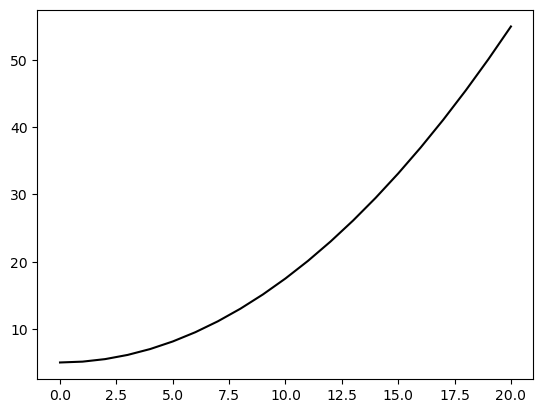

In [49]:
import matplotlib.pyplot as plt

plt.plot(x_opt[0, :],'k-')

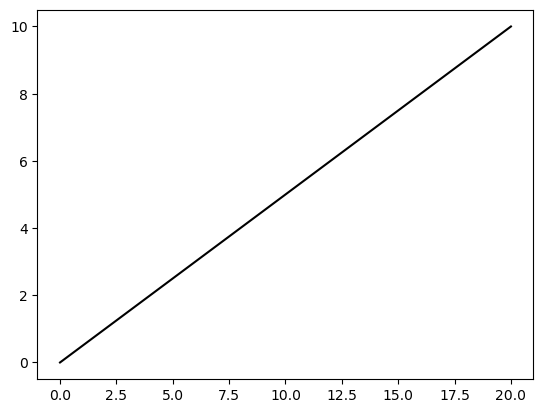

In [50]:
plt.plot(x_opt[1, :],'k-')